This is the code related to chapter 31 of Intuitive Biostatistics 4th (H. Motulsky, OUP, 2018).
We will compare two paired groups.
Note that we are talking about the mean of difference between 'before' and 'after', instead of the difference betweens the means as discussed in chapter 30 (unpaired groups).

### Paired t test

#### Import libraries and data

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# the data come from Table 31.1 on page 307
cross = np.array([23.5, 12, 21, 22, 19.125, 21.5, 22.125, 20.375,
                 18.250, 21.625, 23.250, 21, 22.125, 23, 12])
self =  np.array([17.375, 20.375, 20, 20, 18.375, 18.625, 18.625, 15.25,
                 16.5, 18, 16.25, 18, 12.75, 15.5, 18])

In [11]:
difference = cross - self
print(difference)

[ 6.125 -8.375  1.     2.     0.75   2.875  3.5    5.125  1.75   3.625
  7.     3.     9.375  7.5   -6.   ]


#### Data visualization

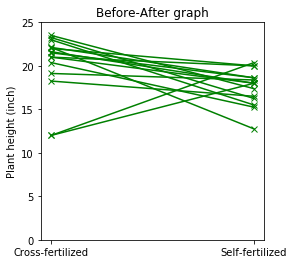

In [12]:
plt.figure(figsize=(4,4))
plt.plot([cross, self], 'gx-')
plt.xticks([0, 1], ['Cross-fertilized', 'Self-fertilized'])
plt.ylim(0, 25)
plt.title('Before-After graph')
plt.ylabel('Plant height (inch)');

#### Descriptive statistics and paired t test

In [13]:
from scipy import stats

In [14]:
mean_diffs = np.mean(cross - self)
print(f"Mean of differences = {mean_diffs:4.3f}")

Mean of differences = 2.617


In [15]:
sem_diffs = stats.sem(cross - self)
print(f"SEM of differences = {sem_diffs:4.3f}")

SEM of differences = 1.218


In [71]:
t_ratio = mean_diffs / sem_diffs
print(f"t ratio = {t_ratio:4.3f}")

t ratio = 2.148


In [16]:
t, p_value = stats.ttest_rel(cross, self)

In [17]:
print(f"P value from paired t test = {p_value:5.4f}")

P value from paired t test = 0.0497


The H0 is there is no difference in the heigth of the 2 kinds of plants, i.e. the differences that we measure are sampled from a population for which the average difference is zero.
The P value is 0.0497. If the H0 were true, 5% of random samples of 15 pairs would have a difference this large of larger.
Assuming that the H0 is true, the probability of observing a difference as large as that observed here with the self-fertilized plants frowing more than the cross-fertilized plants is 0.0248.

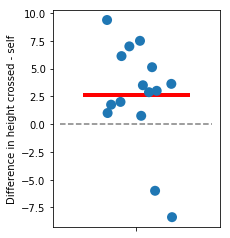

In [19]:
import seaborn as sns
plt.figure(figsize=(3,4))
sns.stripplot(y=cross - self, size=10,)
plt.ylabel('Difference in height crossed - self')
plt.hlines(y=0, xmin=-.2, xmax=.2, colors='gray', linestyles='--')
plt.hlines(y=mean_diffs, xmin=-.14, xmax=.14, colors='red', linewidth=4, label='mean');

#### Computation of the CI

In [18]:
# we compute the ci using the t* distribution and SEM
t_ = stats.t(df = len(cross - self) - 1).ppf((1 + .95) /2) # two-tailed
W = t_ * sem_diffs
print(f"Confidence interval of the mean of differences = {(mean_diffs - W, mean_diffs + W)}")

Confidence interval of the mean of differences = (0.00389916480019048, 5.2294341685331425)


In [21]:
ci_bayes = stats.bayes_mvs(cross - self, alpha=.95)[0][1] # gives the same
print(f"Confidence interval of the mean of differences = {ci_bayes}")

Confidence interval of the mean of differences = (0.00389916480019048, 5.2294341685331425)


#### Bootstraping analysis

In [20]:
diffs_shifted = (cross - self) - mean_diffs + 0 # H0 is difference = 0

In [72]:
bs_diffs_shft = [np.mean(np.random.choice(
    diffs_shifted, size=len(diffs_shifted))) for _ in range(10000)]

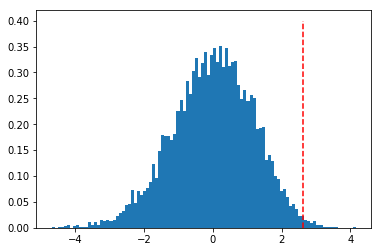

In [73]:
plt.hist(bs_diffs_shft, density=True, bins=100)
plt.vlines(mean_diffs, 0, .4, color='red', linestyles='--');

In [74]:
p_bs = np.sum(bs_diffs_shft >= mean_diffs) / len(bs_diffs_shft)

In [75]:
print(f"P value from bootstraping = {p_bs:5.4f}")

P value from bootstraping = 0.0072


In [25]:
# the last test did not really work, let's try another test statistic (permutation)
# cross_perm = np.random.permutation(cross) will permute the pairs
# we only need to calculate the mean differences over the permuted pairs

In [52]:
bs_mean_diffs = [np.mean(np.random.permutation(cross) - self) for _ in range(10000)]

In [49]:
np.sum(bs_mean_diffs >= mean_diffs) / len(bs_mean_diffs)
# I am still not sure how to handle this situation using bootstap replicates...

1.0

In [76]:
# let's try a test of same distribution
combined = np.concatenate([cross, self])

In [79]:
bs_mean_diffs = []

for _ in range(10000):
    permut = np.random.permutation(combined)
    bs_cross = permut[:len(cross)]
    bs_self  = permut[len(self):]
    
    bs_mean_diffs.append(np.mean(bs_cross - bs_self))

In [80]:
P_value_bs = np.sum(bs_mean_diffs >= mean_diffs) / len(bs_mean_diffs)
print(f"P value obtained using bootstraping = {P_value_bs:7.6f}")

P value obtained using bootstraping = 0.012900


Still not convinced how to do...

#### Correlation

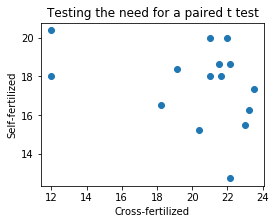

In [66]:
plt.figure(figsize=(4,3))
plt.scatter(cross, self)
plt.title('Testing the need for a paired t test')
plt.xlabel('Cross-fertilized')
plt.ylabel('Self-fertilized');

In [70]:
pearson_r = np.corrcoef(cross, self)[0,1]
print(f"Pearson coeffecient of correlation = {pearson_r:3.2f}")

Pearson coeffecient of correlation = -0.33


### Ratio paired t test

In [82]:
control = np.array([24, 6, 16, 5, 2])
treated = np.array([52, 11, 28, 8, 4])

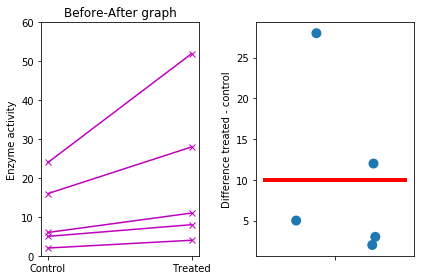

In [98]:
plt.figure(figsize=(6,4))
plt.subplot(121)
plt.plot([control, treated], 'mx-')
plt.xticks([0, 1], ['Control', 'Treated'])
plt.ylim(0, 60)
plt.title('Before-After graph')
plt.ylabel('Enzyme activity')

plt.subplot(122)
sns.stripplot(y=treated - control, size=10,)
plt.ylabel('Difference treated - control')
plt.hlines(y=np.mean(treated - control), xmin=-.14, xmax=.14, 
           colors='red', linewidth=4, label='mean')
plt.tight_layout();

The difference between control and treated depends on where we start. Clones with higher enzyme activity in control condition have a larger increment with treatment.

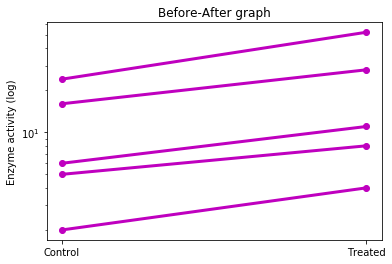

In [104]:
plt.plot([control, treated], 'mo-', lw=3)
plt.xticks([0, 1], ['Control', 'Treated'])
plt.yscale('log')
plt.title('Before-After graph')
plt.ylabel('Enzyme activity (log)'); # with a log y-axis, all five increases are ca. same size

In [108]:
factor = 10 ** (np.mean(np.log10(treated) - np.log10(control)))
print(f"On average the treatment multiplies enzyme activity by {factor:3.2f}")

On average the treatment multiplies enzyme activity by 1.86


In [113]:
t_10, p_value_10 = stats.ttest_rel(np.log10(treated), np.log10(control))
print(f"t and P value for that ratio paired t test are {t_10:5.3f} and {p_value_10:5.4f}")

t and P value for that ratio paired t test are 11.814 and 0.0003


In [111]:
p_value_10

0.00029379575009914015

In [124]:
ci_bayes_log = stats.bayes_mvs(np.log10(treated) - np.log10(control), 
                                 alpha=.95)[0][1]
ci_bayes_ratio = 10 ** np.array(ci_bayes_log)
print(f"Confidence interval of the mean of differences = {ci_bayes_ratio}")

Confidence interval of the mean of differences = [1.60739772 2.15161854]


This interval doesn't include 1.0 (a ratio of 1.0 means no change)